In [904]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [905]:
import numpy as np

from matplotlib import pyplot as plt

import json

import utils

from modules import helpers, fitting

import importlib
importlib.reload(utils)
importlib.reload(helpers)
importlib.reload(fitting)

helpers.set_plot_configs()

In [906]:
DataReader = utils.MCAData()

bins, counts, _, _ = DataReader._read_data('data/2025-03-04/Calibration_recoil_ba_0304.Spe')
count_normalizing_factor = np.sum(counts) * (bins[1] - bins[0])
kde_bins, kde, kde_err = DataReader._kde_smooth_data(bins, counts, bw=5)
peaks_idx, valleys_idx = DataReader._find_peaks_and_valleys(kde_bins, kde, kde_err)

In [907]:
Calibration = utils.MCACalibration('data/2025-03-04/Calibration_scatter_na_0304.Spe',
                                   'data/2025-03-04/Calibration_scatter_ba_0304.Spe')

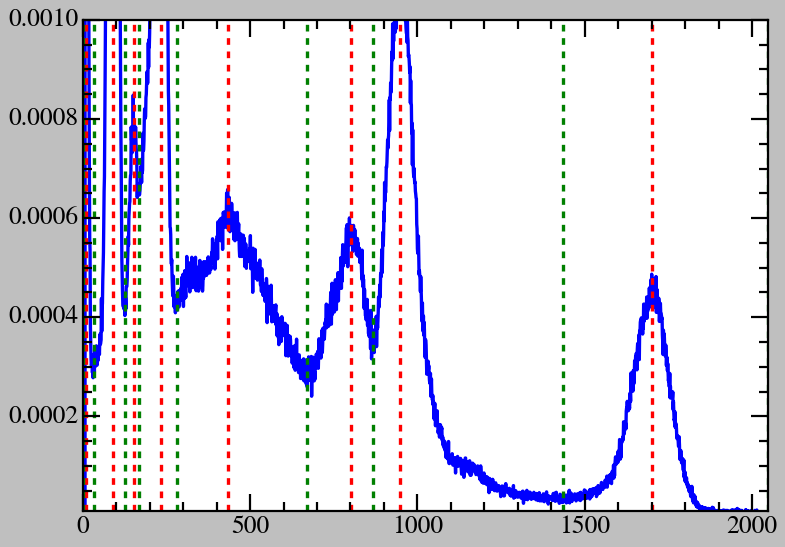

In [908]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(bins, counts/count_normalizing_factor)
# ax.plot(kde_bins, kde)
# ax.errorbar(kde_bins, kde, yerr=kde_err,
#             fmt=' s',markersize=1,elinewidth=2,capsize=5)
for peak_idx in peaks_idx:
    ax.axvline(kde_bins[peak_idx], color='r', linestyle='--')
for valley_idx in valleys_idx:
    ax.axvline(kde_bins[valley_idx], color='g', linestyle='--')

# ax.axvline(fitting_bins[0], color='b', linestyle='--')
# ax.axvline(fitting_bins[-1], color='b', linestyle='--')

# ax.plot(fitting_bins, gaussian_counts/count_normalizing_factor, color='r')

ax.set_xscale('linear')
#ax.set_yscale('log')

ax.set_xlim(0, 2048)
ax.set_ylim(1e-5, 1e-3)

plt.tight_layout()
plt.show()